# Validate Model and Visulize the Result

In [12]:
# Imports and configuration
import torch
import numpy as np
import os
import config
import net
from Dataset import *

model = net.FCNet()
model_file = 'FCNet_2018-10-01-17-25_best.pth'
dataset_type = 'h5' # or img?

In [13]:
# Load models
model_path = os.path.join(config.MODEL_DIR, model_file)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path))
model.eval()

FCNet(
  (fc): Sequential(
    (0): Linear(in_features=591872, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=256, bias=True)
    (4): Dropout(p=0.2)
    (5): PReLU(num_parameters=1)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
  (sigm): Sigmoid()
)

In [14]:
# Load datasets
batch_size = 1
if dataset_type == 'h5':
    feature_file = config.FULL_RESIZED_FEATURE
    image_datasets = {x: SatAerH5Dataset(csv_file=os.path.join(config.MID_PRODUCT, '%s.csv' % x),
                                         feature_file=feature_file) for x in ['train', 'val']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                                  shuffle=True, num_workers=1) for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
else:
    print("Load Data Fail")

In [15]:
# Predict and get prediction matrix
output_matrix = {x: np.zeros(dataset_sizes[x]) for x in ['train', 'val']}
label_matrix = {x: np.zeros(dataset_sizes[x]) for x in ['train', 'val']}
# print(pred_matrix['val'].shape)
import time
since = time.time()
for phase in ['train', 'val']:
    print(phase,"phase:")
    for i_batch, sample_batched in enumerate(dataloaders[phase]):
        print(i_batch+1, '/', dataset_sizes[phase], end = '\r')
        A = sample_batched['A'].to(device)
        B = sample_batched['B'].to(device)
        #labels = sample_batched['label'].to(device)
        with torch.set_grad_enabled(False):
            outputs = model(A,B)
            output_matrix[phase][i_batch] = outputs.data.numpy()[0]
            label_matrix[phase][i_batch] = sample_batched['label'].numpy()[0]
    print()
print((time.time()-since)/(192+48), 'seconds/image (Only time for FC layers)')

train phase:
192 / 192/ 192
val phase:
48 / 48
0.18033676346143088 seconds/image (Only time for FC layers)


In [16]:
pred_matrix = {x: (output_matrix[x] > 0.5)*1 for x in ['train', 'val']}
to_vis_matrix = {x: np.stack((output_matrix[x], pred_matrix[x], label_matrix[x])) for x in ['train', 'val']}
print({x: to_vis_matrix[x].shape for x in ['train', 'val']})

{'train': (3, 192), 'val': (3, 48)}


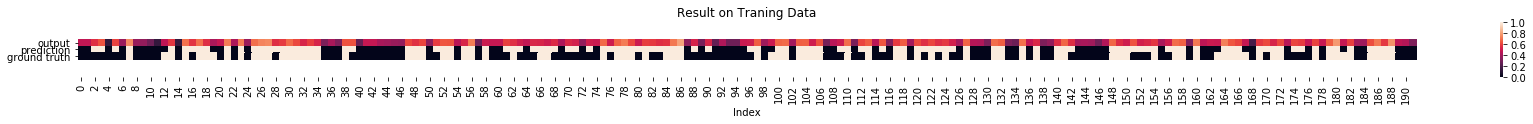

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

fig_size = [30,1]
plt.rcParams["figure.figsize"] = fig_size
plt.axis('equal')
ax = sns.heatmap(to_vis_matrix['train'], yticklabels=['output','prediction','ground truth'])
ax.set_xlabel('Index')
ax.set_title('Result on Traning Data')
plt.show()

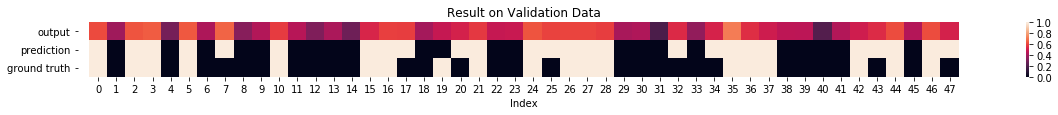

In [18]:
%matplotlib inline

fig_size = [20,1]
plt.rcParams["figure.figsize"] = fig_size
plt.axis('equal')
ax = sns.heatmap(to_vis_matrix['val'], yticklabels=['output','prediction','ground truth'])
ax.set_xlabel('Index')
ax.set_title('Result on Validation Data')
plt.show()

In [19]:
# Analyse the result
def confusion_matrix(pred, gt):
    #n = gt.shape[0]
    P = gt == 1
    N = gt == 0
    
    TP = np.sum(pred[P])
    FP = np.sum(pred[N])
    FN = np.sum(1 - pred[P])
    TN = np.sum(1 - pred[N])
    
    TPR=TP/(TP+FN)
    FPR=FP/(FP+TN)
    ACC = (TP+TN)/(TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2*precision*recall/(precision+recall)
    return TP,FP,TN,FN, TPR,FPR, ACC,precision,recall,F1

for x in ['train', 'val']:
    print(x, 'data TP,FP,TN,FN, TPR,FPR, ACC,precision,recall,F1:')
    print(confusion_matrix(pred_matrix[x], label_matrix[x]))

train data TP,FP,TN,FN, TPR,FPR, ACC,precision,recall,F1:
(78, 35, 73, 6, 0.9285714285714286, 0.32407407407407407, 0.7864583333333334, 0.6902654867256637, 0.9285714285714286, 0.7918781725888325)
val data TP,FP,TN,FN, TPR,FPR, ACC,precision,recall,F1:
(18, 8, 21, 1, 0.9473684210526315, 0.27586206896551724, 0.8125, 0.6923076923076923, 0.9473684210526315, 0.7999999999999999)


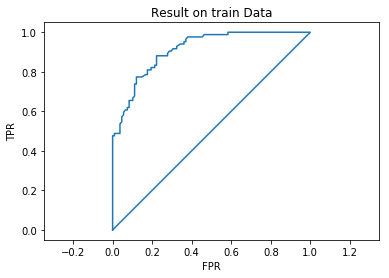

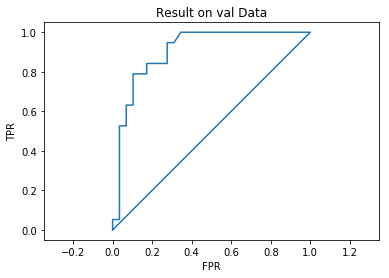

In [20]:
# ROC
np.seterr(divide='ignore',invalid='ignore')
phase = 'train'
for phase in ['train','val']:
    ROC_x, ROC_y = [0], [0]
    for threshold in range(1,1000+1):
        pred_matrix = (output_matrix[phase] > threshold/1000.0)*1
        conf_mat = confusion_matrix(pred_matrix, label_matrix[phase])
        x, y = conf_mat[5], conf_mat[4] # x: FPR, y: TPR
        ROC_x.append(x)
        ROC_y.append(y)
    #ROC_x.append(1)
    #ROC_y.append(1)
    #print(ROC_x,ROC_y)
    %matplotlib inline
    plt.gcf().clear()
    fig_size = [10,10]
    plt.rcParams["figure.figsize"] = fig_size
    plt.axis('equal')
    plt.plot(ROC_x, ROC_y)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.axis('equal')
    plt.title('Result on '+phase+' Data')
    axes = plt.gca()
    #axes.set_xlim([0., 1.])
    plt.show()


## Those wrong classified images

In [21]:
#
phase = 'train'
def sneaky_results(pred, gt):
    P = gt == 1
    N = gt == 0
    FP = np.logical_and(pred != gt, gt==0)
    FN = np.logical_and(pred != gt, gt==1)
    return np.where(FP)[0], np.where(FN)[0]
for x in ['train', 'val']:
    pred_matrix = (output_matrix[x] > .5)*1
    print(sneaky_results(pred_matrix, label_matrix[x]))

(array([  2,   3,   5,  16,  28,  39,  51,  61,  63,  65,  68,  70,  71,
        73,  76,  80,  82,  83,  88,  90,  96, 109, 112, 115, 121, 123,
       125, 142, 151, 152, 153, 156, 170, 174, 175]), array([ 12,  19,  99, 163, 167, 181]))
(array([ 7, 17, 20, 25, 32, 34, 43, 47]), array([19]))


./dataset/full_resized/0034_A.jpg
./dataset/full_resized/0254_A.jpg
./dataset/full_resized/0179_A.jpg
./dataset/full_resized/0284_A.jpg
./dataset/full_resized/0261_A.jpg
./dataset/full_resized/0028_A.jpg


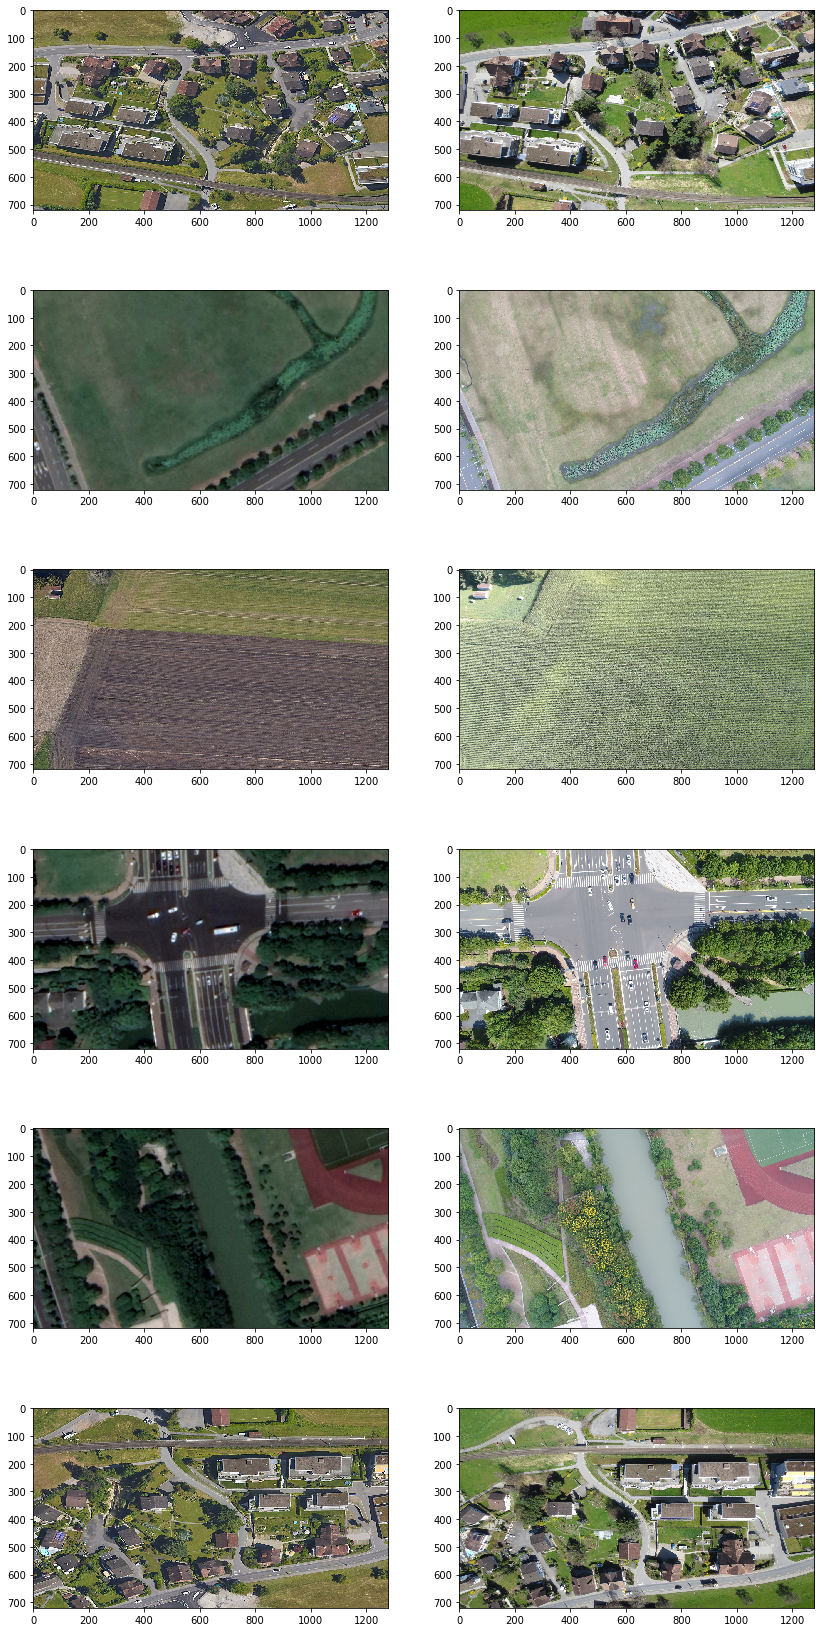

In [22]:
import pandas as pd
from PIL import Image


def draw_images(indices, phase):
    assert phase in ['train', 'val']
    csv_file = os.path.join(config.FULL_RESIZED, '%s.csv' % phase)
    file_frame = pd.read_csv(csv_file)
    columns = 2
    rows = len(indices)
    fig=plt.figure(figsize=(14, 5*rows))
    for i, idx in enumerate(indices):
        A_name = os.path.join(config.FULL_RESIZED, file_frame.iloc[idx,0])
        B_name = os.path.join(config.FULL_RESIZED, file_frame.iloc[idx,1])
        print(A_name)
        A = Image.open(A_name)
        B = Image.open(B_name)
        fig.add_subplot(rows, columns, 2*i+1)
        plt.imshow(A)
        fig.add_subplot(rows, columns, 2*i+2)
        plt.imshow(B)

    plt.show()

phase = 'train'
pred_matrix = (output_matrix[phase] > .5)*1
FP, FN = sneaky_results(pred_matrix, label_matrix[phase])
draw_images(FN.tolist(), phase)

./dataset/full_resized/0009_A.jpg


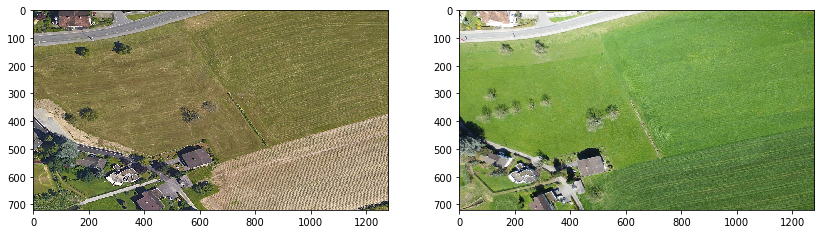

In [26]:
phase = 'val'
pred_matrix = (output_matrix[phase] > .5)*1
FP, FN = sneaky_results(pred_matrix, label_matrix[phase])
draw_images(FN.tolist(), phase)